# Least squares with SGD

In [70]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import urllib
from pathlib import Path
import tarfile
import pandas as pd
import seaborn as sns
import hashlib
import scipy

In [71]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True  # Use per default a grid, i.e. plt.grid()
# mpl.rcParams['figure.figsize'] = [6.4, 4.8]  # Change the default figure size

- `Tab`: Code completion or indent
- `Shift-Tab`: Tooltip
- `Shift-Tab Shift+Tab`: Long tooltip
- `Ctrl-Enter`: Run selected cells
- `Shift-Enter`: Run cell, select below
- `Alt-Enter`: Run cell and insert below
- `Ctrl-#`: Comment
- `Esc a`: New cell above
- `Esc b`: New cell below
- `Esc d d`: Delete current cell
- `Esc m`: Turn current cell into Markdown cell
- `Esc y`: Turn current cell into code cell

# Download the California household prices dataset

- Each row contains data about a block group (600 to 3000 people)
- Some values are missing/ clipped or scaled.

Values in the dataset:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

Inspect the dataset and discuss what the `pairplot` shows.
Does it help to decide, which features might be good to predict `median_house_value`?

For those that use `cocalc.com`:
If you do not have internet access in your Jupyter notebook, you need to download the `housing.tgz` manually and then upload it to your environment just as you uploaded the notebook file.

In [72]:
csv_path = Path('housing.csv')

if not csv_path.is_file():
    remote_url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz'
    local_path = Path('housing.tgz')

    if not local_path.is_file():
        urllib.request.urlretrieve(remote_url, local_path)

    with tarfile.open(local_path) as f:
        f.extractall()

In [73]:
df = pd.read_csv(csv_path)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [75]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [76]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


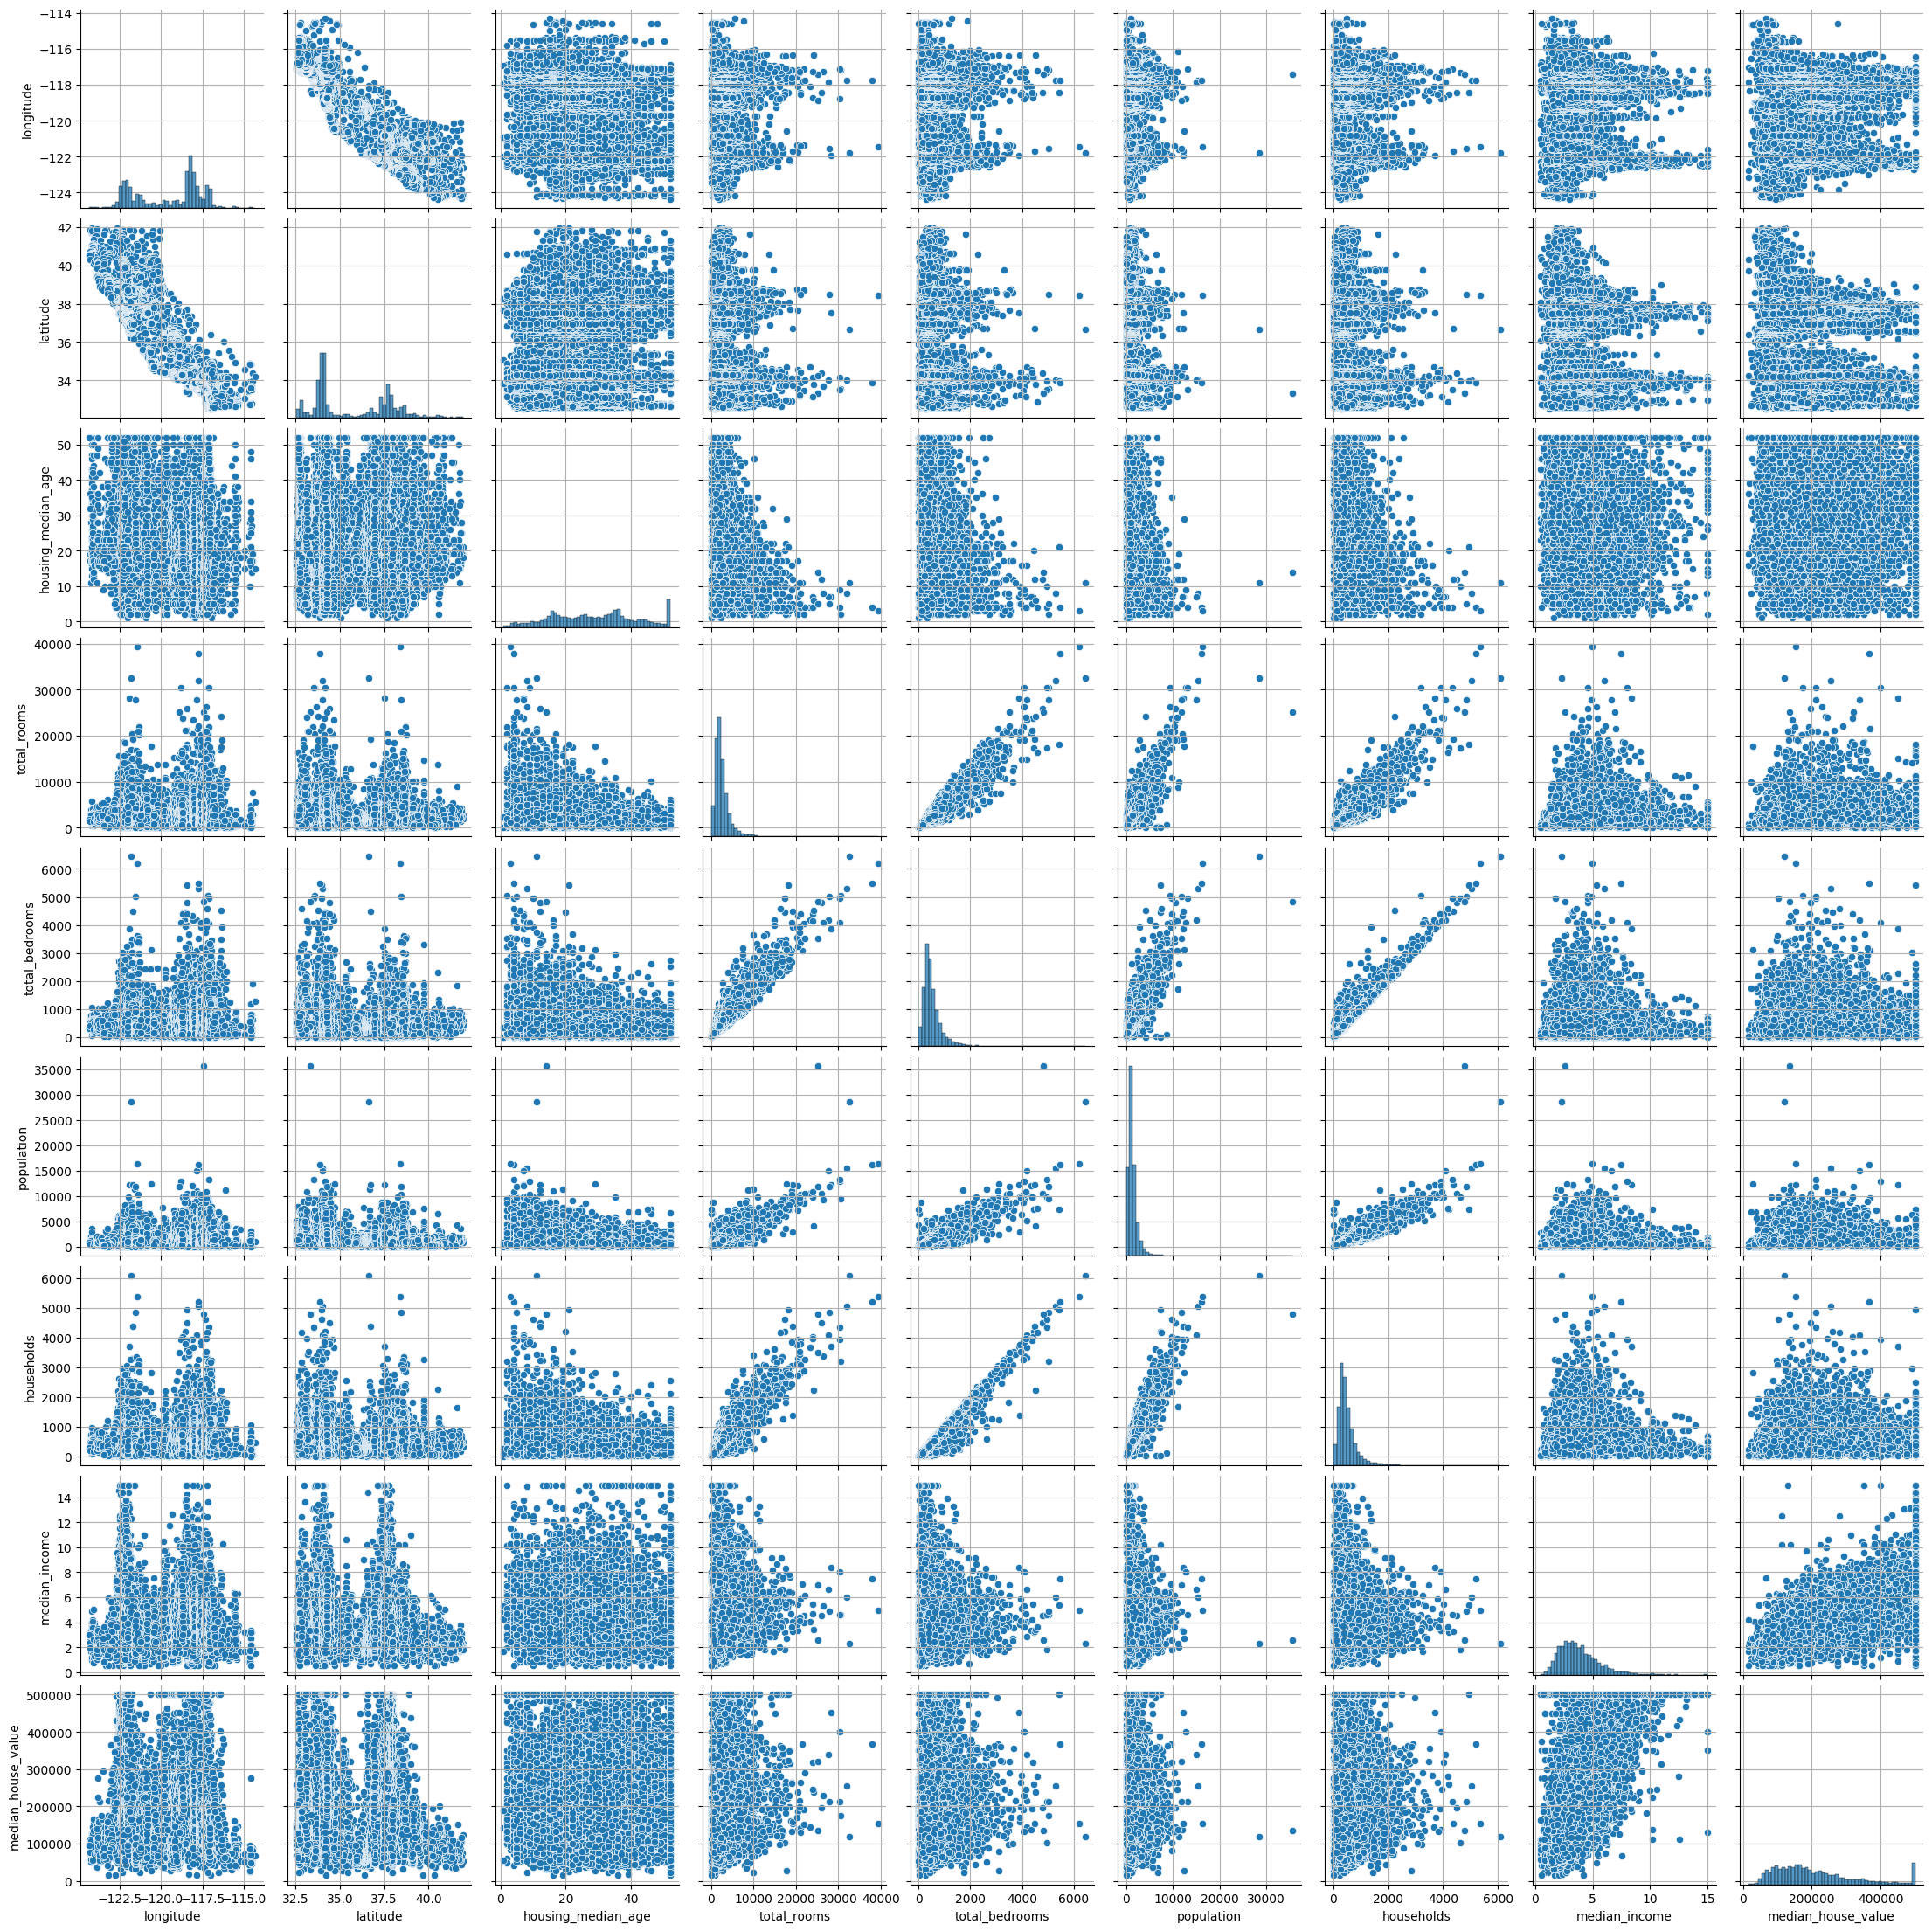

In [77]:
# Check https://seaborn.pydata.org/examples/index.html
sns.pairplot(df.dropna(), diag_kws={'bins': 50});

# Remove missing data and clipped data

When data is missing or is corrupted, you basically have three options:
- Drop the row (i.e. the record containing the missing value)
- Drop the column (i.e. drop the complete feature)
- Fill with a sane default value (often median of the train set, has to be stored for the test conditions later)

In [78]:
# Drops all rows which contain NaN anywhere
df = df.dropna()

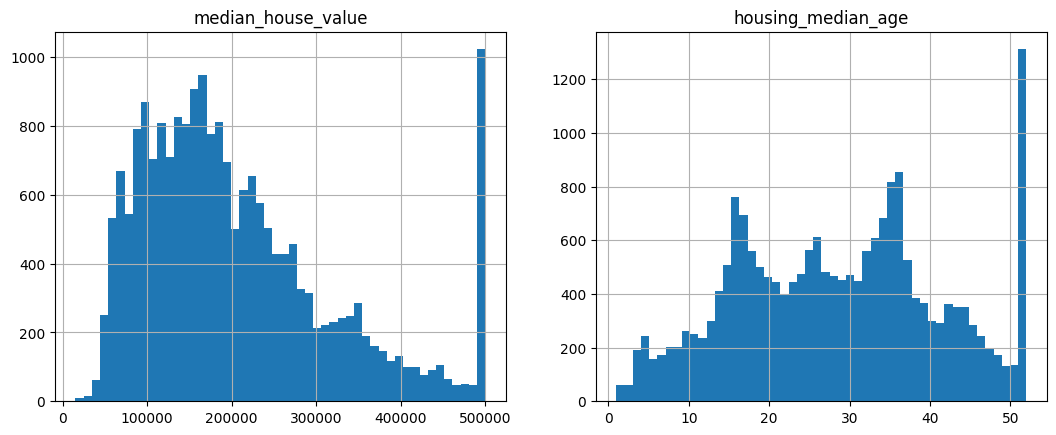

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
for ax, feature in zip(axes, ['median_house_value', 'housing_median_age']):
    ax.hist(df[feature], bins=50)
    ax.set_title(feature)
plt.show()

### Questions:

Are there corrupted values?
 
 - Do you have an idea, why they are corrupted?
 - How can you identify them?
 - Check https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html and remove them.

In [80]:
print(df['median_house_value'].max())
print(df['housing_median_age'].max())

500001.0
52.0


In [81]:
df = df.query('median_house_value < 500001.0')
df = df.query('housing_median_age < 52')

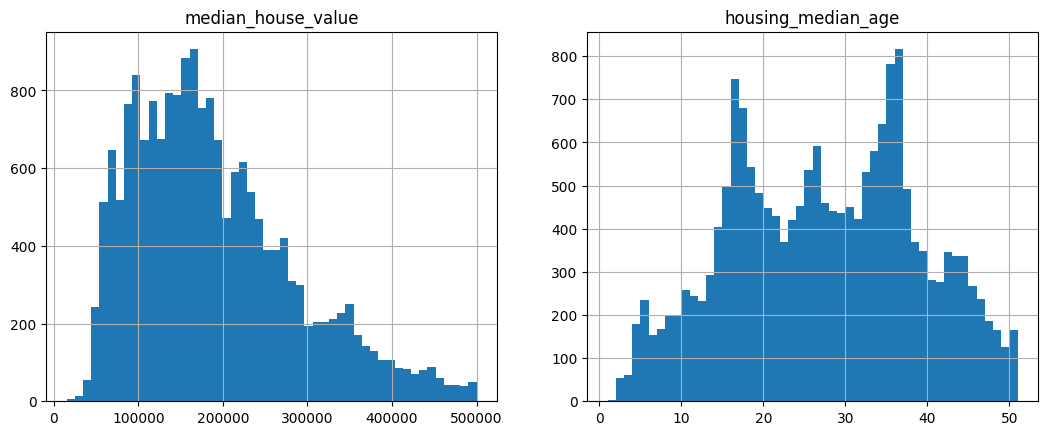

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
for ax, feature in zip(axes, ['median_house_value', 'housing_median_age']):
    ax.hist(df[feature], bins=50)
    ax.set_title(feature)
plt.show()

# Split dataset into subsets

It is absolutely crutial to split the dataset into at least two subsets:
- Train set
- Test set

Often, people tend to split the dataset into three different subsets:
- Train set
- Cross-validation set/ Validation set
- Test set

You would then train on the train set and always check how your algorithm performs on the CV set.
Just for the final results you would run your model once on the test set but not change any parameters afterwards anymore.
The best model has to be selected based on the CV set.

In [83]:
df['_id'] = df.apply(lambda row: '{}_{}'.format(
    row["longitude"],
    row["latitude"]
), axis=1)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,_id
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122.23_37.88
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122.22_37.86
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122.26_37.84
15,-122.26,37.85,50.0,1120.0,283.0,697.0,264.0,2.1250,140000.0,NEAR BAY,-122.26_37.85
18,-122.26,37.84,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY,-122.26_37.84


Now we split the dataset into a train and test set.

### Questions:

 - Do you get a random test set? Depends on the way we look trough the DB
 - Is the test set each time the same set? Depends on the test ratio
 - What would happen, when we get new samples or decide to drop more sample? Would the train/test assignment change?
 I don´t know


In [84]:
def is_in_test_set(key, test_ratio):
    hash_value = hashlib.md5(key.encode()).digest()
    return hash_value[-1] < 256 * test_ratio

def split_train_test(dataframe, test_ratio):
    in_test_set = dataframe._id.apply(lambda _id: is_in_test_set(_id, test_ratio))
    return dataframe.loc[~in_test_set], dataframe.loc[in_test_set]

df_train, df_test = split_train_test(df, 0.2)

In [85]:
print('df:       {}'.format(len(df)))
print('df_train: {}'.format(len(df_train)))
print('df_test:  {}'.format(len(df_test)))

df:       18379
df_train: 14744
df_test:  3635


# Model the median house value based on median income

Fit the ordinary least squares model to predict median house values based on median income.

$y_n = w_0 + w_1 x_n + v_n$ with $v_n \sim \mathcal{N}(0, \sigma_v^2)$

### Matrix notation:
The objective can be written as $J =  \lVert\mathbf{y} - \mathbf{X}\boldsymbol{\theta}\rVert^2$ with 

 - Observation matrix: $\mathbf{X} = \begin{bmatrix} 1 & x_{1,1} & \dots & x_{1,D-1} \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_{N,1} & \dots & x_{N,D-1} \end{bmatrix} \in \mathbb{R}^{N \times (D)} = \mathbb{R}^{14744 \times 2}$
 - Target vector $\mathbf{y} = \begin{bmatrix}y_1\\\vdots\\y_N\end{bmatrix}$
 - Parameter vector $\boldsymbol{\theta} = \begin{bmatrix}w_0\\\vdots\\w_{D-1}\end{bmatrix}$
 
After some simple steps (Try it, it is important to be able to optimize such an objective) we obtain $\boldsymbol{\theta} = (\mathbf{X}^\mathrm{T} \mathbf{X})^{-1} \mathbf{X}^\mathrm{T}\mathbf{y}$

### Questions:
 - The start equation is a polynom with order 1.
   It is easy to see, that this is a linear classifier.
   When we increase the polynom order $y_n = w_0 + w_1 x_n + \dots + w_{D-1} x_n^{D-1} + v_n$, would it be still a linear classifier?
 - Why is there a column of ones in the observation matrix? BCS we have the constant w_0, which does not depend on X
 - Does $(\mathbf{X}^\mathrm{T} \mathbf{X})^{-1}$ exist? Yes, bcs its positiv definit
 - How about $(\mathbf{X} \mathbf{X}^\mathrm{T})^{-1}$? Not shure


In [86]:
ylabel = 'median house value in $'

y = np.asarray(df_train.median_house_value)
y.shape

(14744,)

Now we want to get the Observation matrix $\mathbf{X}$.
Take the vector `df_train.median_house_value` (1D-Array) and convert it to a matrix `X`, where you add a column with ones.

Hints:
 - There are several solutions.
 - One solution is based on `np.stack` and `np.ones_like`


In [87]:
xlabel = 'median income in 10 000 $'

def get_observation_matrix(feature_vector):
    X = np.stack([np.ones_like(feature_vector), feature_vector], axis=1)    
    return X

X = get_observation_matrix(df_train.median_income)
print(X[:5, :])
X.shape

[[1.     8.3252]
 [1.     8.3014]
 [1.     2.0804]
 [1.     2.125 ]
 [1.     1.9911]]


(14744, 2)

Now we want to estimate the parameter vector `theta`.

Hint:
 
 - You may want to use `np.linalg.solve`, `np.linalg.inv`, `np.linalg.pinv` or `scipy.linalg.lstsq`.
 - Are some of them better than others? If yes, why?

In [88]:
theta = np.linalg.inv(X.T @ X) @ X.T @ y 
theta

array([41260.18776931, 40363.41137742])

Plot the training and test data and the regression model.

 - What do you expect?
 - Do you see, what you expected?

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 14744)

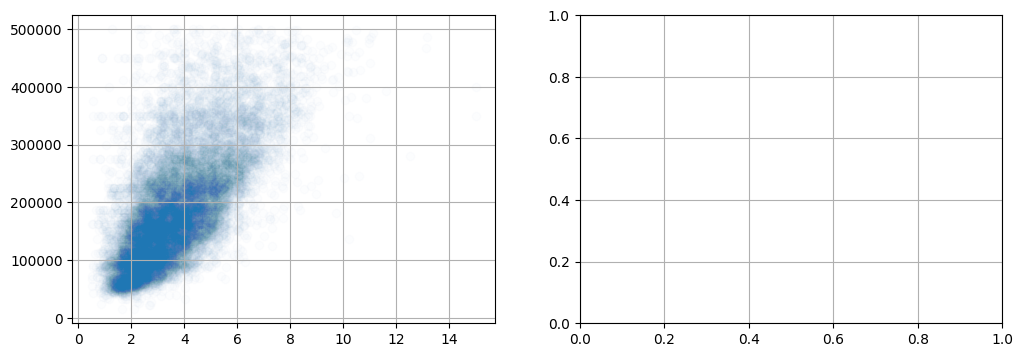

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

def partial_plot(ax, dataframe, title, theta):
    ax.scatter(dataframe.median_income, dataframe.median_house_value, alpha=0.01)
    xp = np.linspace(0, 12, 100)
    yp = X.T @ theta
    ax.plot(xp, yp, color='red')
    ax.set_title(title)
    ax.set_xlim((0, 12))
    ax.set_ylim((0, 500000))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

partial_plot(axes[0], df_train, 'Train set', theta)
partial_plot(axes[1], df_test, 'Test set', theta)

Calculate the root mean squared error of your predictions both on the train and on the test set.

In [ ]:
y_test = np.asarray(df_test.median_house_value)
y_test.shape

(3608,)

In [ ]:
X_test = get_observation_matrix(df_test.median_income)
X_test.shape

(3608, 2)

In [ ]:
def root_mean_squared_error(X, y, theta):
    difference = X @ theta - y 
    assert difference.shape == (X.shape[0],), 'Unexpected shape: {}'.format(difference.shape)
    return np.sqrt(np.mean(difference ** 2))

root_mean_squared_error(X, y, theta)

71600.08576480615

In [ ]:
# Check your root_mean_squared_error implementation with a toy example
rmse = root_mean_squared_error(
    X=np.array([
        [1, 2],
        [1, 3],
        [1, 4],
    ]),
    y=np.array([10, 12, 14]),
    theta=np.array([6, 2])
)
assert rmse == 0, rmse

In [ ]:
X.shape, y.shape, theta.shape

((14589, 2), (14589,), (2,))

In [ ]:
print('Train error: {:10.0f} US$'.format(
    root_mean_squared_error(X, y, theta)
))

print('Test error:  {:10.0f} US$'.format(
    root_mean_squared_error(X_test, y_test, theta)
))

Train error:      71600 US$
Test error:       69495 US$


# Stochastic gradient descent

Implement a (stochastic) gradient descent algorithm to estimate the linear regression parameters.
Ideally, write a function which allows to set different parameter, e.g. mini batch size.
Add some kind of learning rate schedule (i.e. learning rate decreases by a factor of 10 after each epoch after the 5th).

Hints:
 - Objective: $J = \lVert\mathbf{y} - \mathbf{X}\boldsymbol{\theta}\rVert^2$
 - Gradient: $\displaystyle\frac{\partial J}{\partial \boldsymbol{\theta}}$
 - Gradient descent algorithm: $\displaystyle\boldsymbol{\theta}^\mathrm{new} = \boldsymbol{\theta}^\mathrm{old} - \mu \left.\frac{\partial J}{\partial \boldsymbol{\theta}}\right|_{\boldsymbol{\theta} = \boldsymbol{\theta}^\mathrm{old}}$ where $\mu$ is the learning rate
 - Stochastic gradient descent algorithm: Use gradient descent algorithm with a subset of $\mathbf{X}$ (i.e. mini batch)
    - Important: Shuffle the training data. Often they are sorted and then the mini batch is far away to be representative for the complete data.
 - Epoch: One epoch means, that you processed all training data one time.

Functions you may want to use:
 - `np.random.shuffle`
 - `np.array_split`

In [ ]:
def get_learning_rate(epoch):
    # This is a fixed learning rate schedule.
    ???
    return ???

def get_gradient_theta(X, y, theta):
    return ???

def fit(
    X_train, y_train,
    X_test, y_test,
    epochs=10,
    batch_size=10,
    logging=True
):
    number_of_examples, number_of_parameters = X_train.shape
    
    # Set up batching parameters
    all_example_indices = list(range(number_of_examples))
    number_of_batches = -(-number_of_examples // batch_size)
    
    # Initialize variables
    theta = np.zeros(number_of_parameters)
    
    # Prepare logging
    if logging:
        train_error_history = []
        test_error_history = []
        theta_history = []
    else:
        train_error_history = None
        test_error_history = None
        theta_history = None
    
    for epoch in range(epochs):
        learning_rate = get_learning_rate(epoch)
        ???  # shuffle all_example_indices
        
        ???  # for mini_batch in ???:
            ???
            
            if logging:
                theta_history.append(theta)
                train_error_history.append(
                    root_mean_squared_error(X_train, y_train, theta)
                )
                test_error_history.append(
                    root_mean_squared_error(X_test, y_test, theta)
                )
    
    if logging:
        train_error_history = np.asarray(train_error_history)
        test_error_history = np.asarray(test_error_history)
        theta_history = np.asarray(theta_history)
    
    return theta, train_error_history, test_error_history, theta_history

theta, train_error_history, test_error_history, theta_history = fit(
    X, y,
    X_test, y_test,
    epochs=10,
    batch_size=10,
    logging=True
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

ax = axes[0]
ax.plot(np.log(train_error_history), label='Train error')
ax.plot(np.log(test_error_history), color='red', label='Test error')
ax.set_xlabel('Iteration')
ax.set_ylabel('Root Mean Squared Error')
ax.legend()

ax = axes[1]
ax.plot(theta_history[:, 0], theta_history[:, 1])
ax.scatter(theta[0], theta[1], color='red', zorder=3, s=100)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')

plt.show()
print('Best test loss: {:10.0f}'.format(np.min(test_error_history)))

# For experts...

- Check the somewhat famous paper [1] from Yoshua Bengio. Especially Section 2 is worth a read. Also Section 3.1.1 provides useful information about learning rate schedules and other hyper-parameters.
- Implement early stopping (stop when CV loss does not decrease for a few epochs).
- Implement learning rate back-off based on CV loss.

You can also add more features from the dataset to try to predict the prices better.
How would you use the `ocean_proximity` feature.

- [1] https://arxiv.org/pdf/1206.5533.pdf